<a href="https://colab.research.google.com/github/TatsukiIshijima/Colab_Notebooks/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAI Gym で CartPole を試す


### OpenAI Gym の確認

In [ ]:
import gym
print(gym.__version__)

0.17.3


### OpenAI Gym の描画準備
`pyvirtualdisplay` と `python-opengl` のインストール

In [ ]:
!pip install pyvirtualdisplay
!apt install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


描画用の関数を追加

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

ランダムに動かした Gym の環境描画してみる

In [ ]:
env = wrap_env(gym.make('CartPole-v1'))

for episode in range(20):
    observation = env.reset()

    for step in range(100):
    
        env.render()    
        action = env.action_space.sample() 
        observation, reward, done, info = env.step(action) 
    
        if done: 
            break;
    
    print('Episode {0} finished after {1} timesteps'.format(episode+1, step+1))
            
env.close()
show_video()

Episode 1 finished after 10 timesteps
Episode 2 finished after 13 timesteps
Episode 3 finished after 15 timesteps
Episode 4 finished after 19 timesteps
Episode 5 finished after 29 timesteps
Episode 6 finished after 21 timesteps
Episode 7 finished after 21 timesteps
Episode 8 finished after 29 timesteps
Episode 9 finished after 16 timesteps
Episode 10 finished after 16 timesteps
Episode 11 finished after 19 timesteps
Episode 12 finished after 13 timesteps
Episode 13 finished after 15 timesteps
Episode 14 finished after 85 timesteps
Episode 15 finished after 21 timesteps
Episode 16 finished after 11 timesteps
Episode 17 finished after 10 timesteps
Episode 18 finished after 17 timesteps
Episode 19 finished after 30 timesteps
Episode 20 finished after 20 timesteps


### 棒の角度から動く方向を決定するエージェント

CartPole の観測データと行動の定義は [CartPole v0](https://github.com/openai/gym/wiki/CartPole-v0#observation) に記載されている。こちらを確認すると Observation は Box 型で Pole Angle 含まれているのでこれを用いて動く方向（Action）を決める。Action は 0 と 1 のみで 0 のときは台車を左へ移動、1 のときは右となっている

In [ ]:
env = wrap_env(gym.make('CartPole-v1'))

# ステップ数が長くなったか後にグラフで確認するためにステップ数を保持する
steps = []

for episode in range(20):
    observation = env.reset()

    for step in range(200):

        env.render()
        cart_pos, cart_vel, pole_ang, pole_vel = observation

        # 棒の角度が左に倒れそうなら、台車を左へ
        if pole_ang < 0:
            action = 0
        # 棒の角度が右に倒れそうなら、台車を右へ
        else:
            action = 1

        observation, reward, done, info = env.step(action)
        
        if done:
            break
        
    print('Episode {} finished after {} timesteps'.format(episode+1, step+1))
    steps.append(step+1)

env.close()
show_video()


Episode 1 finished after 41 timesteps
Episode 2 finished after 45 timesteps
Episode 3 finished after 26 timesteps
Episode 4 finished after 34 timesteps
Episode 5 finished after 38 timesteps
Episode 6 finished after 44 timesteps
Episode 7 finished after 38 timesteps
Episode 8 finished after 52 timesteps
Episode 9 finished after 35 timesteps
Episode 10 finished after 31 timesteps
Episode 11 finished after 51 timesteps
Episode 12 finished after 38 timesteps
Episode 13 finished after 45 timesteps
Episode 14 finished after 35 timesteps
Episode 15 finished after 53 timesteps
Episode 16 finished after 40 timesteps
Episode 17 finished after 62 timesteps
Episode 18 finished after 40 timesteps
Episode 19 finished after 46 timesteps
Episode 20 finished after 41 timesteps


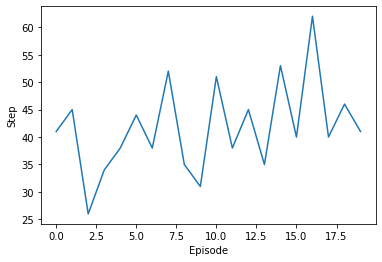

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(steps)
plt.xlabel('Episode')
plt.ylabel('Step')
plt.show()

### Q-Learning を用いたエージェント

観測データ(Observation)は Box 型で4つの要素（Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip）を持っている。これらは連続値なので、まずは量子化する。今回はこれらの値を５段階に分けて定義する。

#### Observation (Type: Box(4))

|  要素数 |  名前  | 最小 | 最大 |
| :---- | :---- | :---- | :---- |
|  0  |  Cart Position  | -2.4 | 2.4 |
|  1  |  Cart Velocity  | -inf | inf |
|  2  |  Pole Angle  | -41.8° | 41.8° |
|  3  |  Pole Velocity At Top  | -inf | inf |

#### Observation の量子化
以下のように連続値を5つの範囲に分割し、量子化する。Observation の4要素を5つに分割したので状態の数は 5^4 = 625 個あることになる。

| 要素 | 0 | 1 | 2 | 3 | 4 |
| :---- | :---- | :---- | :---- | :---- | :---- |
Cart Position  | Pos < -1.2  | -1.2 <= Pos < -0.2 | -0.2 <= Pos < 0.2 | 0.2 <= Pos < 1.2 | 1.2 <= Pos |
Cart Velocity  | Vec < -1.5  | -1.5 <= Vec < -0.2 | -0.2 <= Vec < 0.2 | 0.2 <= Vec < 1.5 | 1.5 <= Vec |
Pole Angle | Ang < -0.25  | -0.25 <= Ang < -0.02 | -0.02 <= Ang < 0.02 | 0.2 <= Ang < 0.25 | 0.25 <= Ang |
Pole Velocity At Tip  | P < -1.0  | -1.0 <= P < -0.2 | -0.2 <= P < 0.2 | 0.2 <= P < 1.0 | 1.0 <= P |

#### Q-Learning
状態数が 625 個で起こす行動（Action）は左(0)か右の(1)の2択。よって、Q-table (Q(s, a))は (625, 2) の行列で表せる。これは状態と行動が関連付けられていることを示し、この行列の各値がある状態の時にある行動の選ばれやすさを示す。Q-Learning はこの行動の選ばれやすさの値を更新していく学習方法。  

$$ Q(s_t, a_t) = Q(s_t, a_t) + η(R_{t+1} + γ max Q(s_{t+1}, a) - Q(s_t, a_t)) $$
  
η：学習係数（定数）
γ：割引率（定数）
R：報酬


#### ε-greddy法
Q-table の各値（Q値）が正しく決まっていない状態で、行動の選ばれやすさ（Q値）が大きい方を選ぶという試行だと、Q-table の初期値に依存してしまうため学習がうまく進まない問題がある。そこで適当な閾値（ε）を決め、行動選択の時に 0~1 の乱数を生成し、この乱数がε以下であればランダムに行動を選択する。εより大きければQ値が大きい方の行動を選択するという方法をとることで対応する。なお、εはエピソードが増えるごとに小さくなるよう設定する。

エージェントの作成

In [ ]:
import numpy as np
import random

class Agent:
    def __init__(self):
        # Q-table
        self.__Q = np.zeros((5**4, 2))
        # 最後の状態
        self.__last_s = None
        # 最後の行動
        self.__last_a = None
        # 学習係数
        self.__eta = 0.2
        # 割引率
        self.__gamma = 0.99

    def quantize5(self, x, a, b):
        """
        量子化（５段階）
        """
        return 0 if x < -a else 1 if x < -b else \
            2 if x <= b else 3 if x <= a else 4
        
    def quantize(self, observation):
        """
        量子化した変数をまとめて一つの値に変換する
        5段階に量子化した場合は5進数の値（0~624）に変換する
        """
        pos = self.quantize5(observation[0], 1.2, 0.2)
        vel = self.quantize5(observation[1], 1.5, 0.2)
        ang = self.quantize5(observation[2], 0.25, 0.02)
        acc = self.quantize5(observation[3], 1.0, 0.2)
        return pos  * pow(5, 0) + vel * pow(5, 1) + ang * pow(5, 2) + acc * pow(5, 3)

    def action(self, observation, episode, reward):
        """
        Q学習により行動を決める

        Parameters
        ----------------
        observation : 観測データ
        episode : エピソード数
        reward : 報酬
        """
        s = self.quantize(observation)
        #ε-greedy法
        # エピソードが増えるにつれ、小さくなる閾値変数(ε)
        epsilon = 0.5 * (1 / (episode + 1))
        # 閾値より大きい場合はある状態(s)の時にQ値が大きい行動をとる
        # 閾値以下場合はランダムで行動をとる（左 or 右）
        if random.random() > epsilon:
            a = np.argmax(self.__Q[s, :])
        else:
            a = random.randint(0, 1)

        # Q値の更新
        if self.__last_s is not None:
            q = self.__Q[self.__last_s, self.__last_a]
            self.__Q[self.__last_s, self.__last_a] = \
                q + self.__eta * (reward + self.__gamma * np.max(self.__Q[s, :]) - q)
        self.__last_s = s
        self.__last_a = a
        return a

実際に学習させてみる

In [ ]:
env = wrap_env(gym.make('CartPole-v1'))
# CartPole-v1 のデフォルトのステップ数に達する前に env.reset を呼ぶとエラーになるので
# ステップ数を新たに指定し、done のフラグをステップ数が終わった時に返されるようにする
env.spec.max_episode_steps = 200

agent = Agent()

steps = []
for episode in range(20):
    observation = env.reset()

    reward = 0
    for step in range(200):
        #env.render()
        action = agent.action(observation, episode, reward)
        observation, reward, done, info = env.step(action)
        # 終了してしまったら、報酬を低くする
        if done:
            agent.action(observation, episode, -200)
            break
    
    print('Episode {} finished after {} timesteps'.format(episode+1, step+1))
    steps.append(step+1)

env.close()
show_video()

Episode 1 finished after 8 timesteps
Episode 2 finished after 11 timesteps
Episode 3 finished after 8 timesteps
Episode 4 finished after 21 timesteps
Episode 5 finished after 33 timesteps
Episode 6 finished after 36 timesteps
Episode 7 finished after 62 timesteps
Episode 8 finished after 54 timesteps
Episode 9 finished after 79 timesteps
Episode 10 finished after 52 timesteps
Episode 11 finished after 82 timesteps
Episode 12 finished after 111 timesteps
Episode 13 finished after 103 timesteps
Episode 14 finished after 71 timesteps
Episode 15 finished after 109 timesteps
Episode 16 finished after 130 timesteps
Episode 17 finished after 120 timesteps
Episode 18 finished after 112 timesteps
Episode 19 finished after 133 timesteps
Episode 20 finished after 130 timesteps


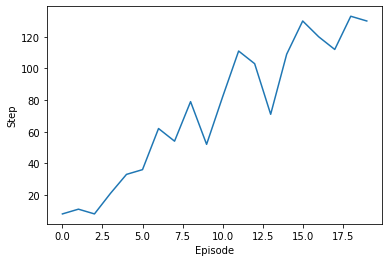

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(steps)
plt.xlabel('Episode')
plt.ylabel('Step')
plt.show()

### まとめ
以下３パターンで CartPole 問題を実践してみた。ランダムの場合はステップ毎の乱数に依存するため、 CartPole 問題を長く続けることは不可能であった。棒の角度から行動を決めるパターンでは、ランダムよりかは長く続けることは可能であるが、ある一定の期間までしか対応できなかった。Q-Learning を用いた場合では状態に応じて行動を決めるため、棒を倒さずに CartPole を続けることが可能だった。

- ランダムで台車の動く方向（左か右の行動）を決めてみる
- 棒の角度から台車の動く方向（左か右の行動）を決めてみる
- Q-Learning を用いてある状態に対しての行動を学習し、台車の動く方向を決めてみる（左か右の行動）